# Giris
**Özel eğitim: adım adım anlatım**<br>
Yeni bir bölümden merhaba! Bu bölümde, özelleştirme (customization) konusunun son çalışmasını gerçekleştireceğiz. Bu eğitimde, penguenleri türlerine göre kategorilere ayırmak için özel bir eğitim döngüsüyle bir makine öğrenimi modelinin nasıl eğitileceği gösterilmektedir. Bu not defterinde, TensorFlow'u kullanarak aşağıdakileri gerçekleştireceksiniz:
- Bir veri kümesini içe aktarın
- Basit bir doğrusal model oluşturun
- Modeli eğit
- Modelin etkinliğini değerlendirin
- Tahminlerde bulunmak için eğitilmiş modeli kullanın

# Penguen sınıflandırma problemi
Her pengueni kategorize etmenin otomatik bir yolunu arayan bir ornitolog olduğunuzu hayal edin. Makine öğrenmesi penguenleri istatistiksel olarak sınıflandırmak için birçok algoritma sağlar. Örneğin, gelişmiş bir makine öğrenmesi programı penguenleri fotoğraflara göre sınıflandırabilir. Bu eğitimde inşa edeceğiniz model biraz daha basittir. Penguenleri vücut ağırlıklarına, yüzgeç uzunluklarına ve gagalarına, özellikle de culmenlerinin uzunluk ve genişlik ölçümlerine göre sınıflandırır.

18 tür penguen vardır, ancak bu eğitimde yalnızca aşağıdaki üç türü sınıflandırmaya çalışacaksınız:
- Chinstrap penguins(Çene kayışlı penguenler)
- Gentoo penguins(Gentoo penguenleri)
- Adélie penguins(Adelie penguenleri)

# Kurmak

In [1]:
# Ardından Colab çalışma zamanını yeniden başlatmak için Colab menüsünden Çalışma Zamanı > Çalışma Zamanını Yeniden Başlat'ı seçin.
# Çalışma zamanını yeniden başlatmadan bu eğitimin geri kalanını sürdürmeyin.
# TensorFlow'u ve diğer gerekli Python modüllerini içe aktarın.
!pip install -q tfds-nightly

In [2]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print('Tensorflow versiyon: ', tf.__version__)
print('Tensorflow Datasets versiyon: ', tfds.__version__)

Tensorflow versiyon:  2.18.0
Tensorflow Datasets versiyon:  4.9.7+nightly


# Veri setini içe aktar
Varsayılan penguenler/işlenmiş TensorFlow Veri Kümesi zaten temizlenmiş, normalleştirilmiş ve bir model oluşturmaya hazır.

## Verileri Incelemesi
Bu veri setinde 344 veri kaydı bulunmaktadır.

In [3]:
ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': float32,
    'culmen_depth_mm': float32,
    'culmen_length_mm': float32,
    'flipper_length_mm': float32,
    'island': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})


Numaralandırılmış satırlar, satır başına bir örnek olmak üzere veri kayıtlarıdır; burada:
- İlk altı alan özelliklerdir: bunlar bir örneğin karakteristikleridir. Burada, alanlar penguen ölçümlerini temsil eden sayıları tutar.
- Son sütun etikettir: bu tahmin etmek istediğiniz değerdir. Bu veri kümesi için, bir penguen türü adına karşılık gelen 0, 1 veya 2'lik bir tam sayı değeridir.

Veri setinde, penguen türü etiketi, oluşturduğunuz modelde çalışmayı kolaylaştırmak için bir sayı olarak gösterilir. Bu sayılar aşağıdaki penguen türlerine karşılık gelir:
- 0: Adélie penguin
- 1: Chinstrap penguin
- 2: Gentoo penguin

In [26]:
# Bu sırayla penguen türü adlarını içeren bir liste oluşturun. Bu listeyi sınıflandırma modelinin çıktısını yorumlamak için kullanacaksınız:
class_names = ['Adélie', 'Chinstrap', 'Gentoo']

## Önceden işlenmiş veri setini indirin


In [6]:
ds_split, info = tfds.load('penguins/processed', split = ['train[:20%]', 'train[20%:]'], as_supervised = True, with_info = True)
ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print('Test dataset ornegi:')
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print('Train dataset ornegi:')
print(df_train)

ds_train_batch = ds_train.batch(32)

FeaturesDict({
    'features': Tensor(shape=(4,), dtype=float32),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})
Test dataset ornegi:
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2
Train dataset ornegi:
                                         features  species
0  [0.49818182, 0.6904762, 0.42372882, 0.4027778]        0
1      [0.48, 0.071428575, 0.6440678, 0.44444445]        2
2    [0.7236364, 0.9047619, 0.6440678, 0.5833333]        1
3  [0.34545454, 0.5833333, 0.33898306, 0.3472222]        0
4       [0.10909091, 0.75, 0.3559322, 0.41666666]        0


In [7]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)

tf.Tensor(
[[0.49818182 0.6904762  0.42372882 0.4027778 ]
 [0.48       0.07142857 0.6440678  0.44444445]
 [0.7236364  0.9047619  0.6440678  0.5833333 ]
 [0.34545454 0.5833333  0.33898306 0.3472222 ]
 [0.10909091 0.75       0.3559322  0.41666666]
 [0.6690909  0.63095236 0.47457626 0.19444445]
 [0.8036364  0.9166667  0.4915254  0.44444445]
 [0.4909091  0.75       0.37288135 0.22916667]
 [0.33454546 0.85714287 0.37288135 0.2361111 ]
 [0.32       0.41666666 0.2542373  0.1388889 ]
 [0.41454545 0.5952381  0.5084746  0.19444445]
 [0.14909092 0.48809522 0.2542373  0.125     ]
 [0.23636363 0.4642857  0.27118644 0.05555556]
 [0.22181818 0.5952381  0.22033899 0.3472222 ]
 [0.24727273 0.5595238  0.15254237 0.25694445]
 [0.63272727 0.35714287 0.88135594 0.8194444 ]
 [0.47272727 0.15476191 0.6440678  0.4722222 ]
 [0.6036364  0.23809524 0.84745765 0.7361111 ]
 [0.26909092 0.5595238  0.27118644 0.16666667]
 [0.28       0.71428573 0.20338982 0.5416667 ]
 [0.10545454 0.5714286  0.33898306 0.2847222 ]
 [

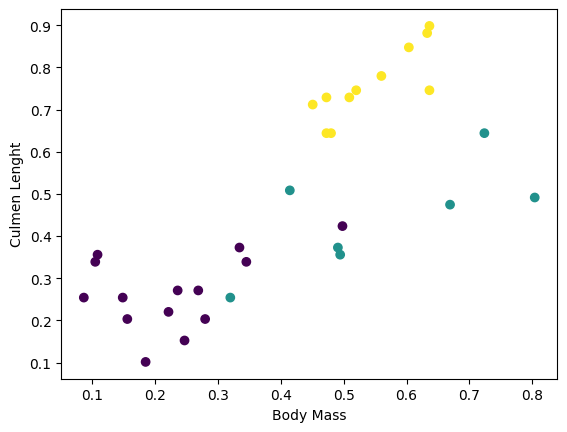

In [8]:
plt.scatter(features[:,0],
            features[:,2],
            c = labels,
            cmap = 'viridis')

plt.xlabel('Body Mass')
plt.ylabel('Culmen Lenght')
plt.show()

# Build a simple linear model

**Neden Model?**<br>
Model, özellikler ile etiket arasındaki ilişkidir. Penguen sınıflandırma problemi için model, vücut kütlesi, yüzgeç ve culmen ölçümleri ile tahmin edilen penguen türü arasındaki ilişkiyi tanımlamaktadır. Bu veri seti, bize verilen türlerin verilerini içermektedir. Model, türlerin verilerinden yola çıkarak penguen türlerini tahmin etmeye çalışır.

Bazı basit modeller birkaç satır cebirle açıklanabilir, ancak karmaşık makine öğrenimi modelleri özetlenmesi zor olan çok sayıda parametreye sahiptir.

Makine öğrenimini kullanmadan, dört özellik ile penguen türü arasındaki ilişkiyi belirleyebilir misiniz? Yani, bir model oluşturmak için geleneksel programlama tekniklerini (örneğin, çok sayıda koşullu ifade) kullanabilir misiniz? Belki de veri setini belirli bir türe ait vücut kütlesi ile culmen ölçümleri arasındaki ilişkileri belirleyecek kadar uzun süre analiz ederseniz... Ancak, bu durum daha karmaşık veri kümelerinde zorlaşır, hatta imkansız hale gelir.

İmkansız hale gelme sebebi şudur: Bu veri setinde, bir penguenin 4 özellik verisi bulunmaktadır ve bunu analiz edebilirsiniz. Ancak, elinizde 12 sınıflı ve her sınıfın 20 özellik verisini içeren bir veri seti olduğunda, bu 12 sınıfın tahminini yapmak yıllarınızı alabilir.

İyi bir makine öğrenimi yaklaşımı sizin için modeli belirler. Doğru makine öğrenimi model türüne yeterli sayıda temsili örnek sağlarsanız, program sizin için ilişkileri belirler.

**Modeli seçin**<br>
Daha sonra eğiteceğiniz model türünü seçmeniz gerekiyor. Modellerin birçok çeşidi var ve iyi bir model seçmek deneyim gerektiriyor. Bu eğitimde penguen sınıflandırma problemini çözmek için bir sinir ağı kullanılıyor. Yapay sinir ağları, özellikler ile etiket arasındaki karmaşık ilişkileri bulabilir. Bir veya daha fazla gizli katmana ayrılmış, oldukça yapılandırılmış bir grafiktir. Her gizli katman bir veya daha fazla nörondan oluşur. Sinir ağlarının birkaç kategorisi vardır ve bu program yoğun veya tam bağlantılı bir sinir ağı kullanır: bir katmandaki nöronlar, önceki katmandaki her nörondan giriş bağlantıları alır. Örneğin, Şekil 2, bir giriş katmanından, iki gizli katmandan ve bir çıktı katmanından oluşan yoğun bir sinir ağını göstermektedir:
![](https://www.tensorflow.org/tutorials/customization/images/full_network_penguin.png)

Şekil 2'deki modeli eğittiğinizde ve ona etiketsiz bir örnek verdiğinizde, üç tahmin elde edersiniz: bu penguenin verilen penguen türü olma olasılığı. Bu öngörüye çıkarım denir. Bu örnek için çıktı tahminlerinin toplamı 1,0'dır. Şekil 2'de bu tahmin şu şekilde dağılır: Adelie için 0,02, Chinstrap için 0,95 ve Gentoo türleri için 0,03. Bu, modelin etiketlenmemiş bir örnek penguenin Chinstrap pengueni olduğunu %95 olasılıkla tahmin ettiği anlamına gelir.

## Keras kullanarak bir model oluşturun
tf.keras.Sequential modeli katmanların doğrusal bir yığınıdır. Oluşturucusu, katman örneklerinin bir listesini alır, bu durumda, her biri 10 düğümlü iki tf.keras.layers.Dense katmanı ve etiket tahminlerinizi temsil eden 3 düğümlü bir çıktı katmanı.

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape = (4,)),
    tf.keras.layers.Dense(10, activation = tf.nn.relu),
    tf.keras.layers.Dense(3)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

Aktivasyon fonksiyonu, katmandaki her bir düğümün çıktı şeklini belirler. Bu doğrusal olmayanlıklar önemlidir—onlar olmadan model tek bir katmana eşdeğer olurdu. Birçok tf.keras.activation vardır, ancak ReLU gizli katmanlar için yaygındır.

Gizli katman ve nöronların ideal sayısı, probleme ve veri setine göre değişmektedir. Makine öğrenmesinin pek çok alanında olduğu gibi, sinir ağının en iyi şeklini seçmek de bilgi ve deneyimin bir karışımını gerektirir. Kural olarak, gizli katman ve nöron sayısını artırmak genellikle daha güçlü bir model yaratır ve bu da etkili bir şekilde eğitmek için daha fazla veri gerektirir.

İşte yaygın olarak kullanılan bazı aktivasyon fonksiyonları ve kullanım alanları:

1. Sigmoid:<br>
- Formül: f(x) = 1 / (1 + exp(-x))
- Çıktı Aralığı: 0 ile 1 arasında
- Kullanım Alanları: İkili sınıflandırma problemleri (örneğin, bir görüntünün kedi mi köpek mi olduğunu tahmin etmek).

2. ReLU (Rectified Linear Unit):<br>
- Formül: f(x) = max(0, x)
- Çıktı Aralığı: 0 veya pozitif bir sayı
- Kullanım Alanları: Görüntü sınıflandırma, nesne tanıma gibi birçok derin öğrenme modelinde yaygın olarak kullanılır. Hızlı ve etkili olması nedeniyle tercih edilir.

3. Tanh (Hiperbolik Tanjant):<br>
- Formül: f(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
- Çıktı Aralığı: -1 ile 1 arasında
- Kullanım Alanları: Sigmoid'e benzer ancak çıktısı 0 merkezli olduğu için bazı durumlarda daha iyi performans gösterebilir.

4. Softmax:<br>
- Formül: f(x_i) = exp(x_i) / sum(exp(x_j)) (j, tüm çıktı nöronları üzerinde)
- Çıktı Aralığı: 0 ile 1 arasında, tüm çıktıların toplamı 1'dir.
- Kullanım Alanları: Çok sınıflı sınıflandırma problemleri (örneğin, bir görüntünün 10 farklı nesneden hangisine ait olduğunu tahmin etmek). Çıktıları olasılık dağılımı olarak yorumlanabilir.

En Çok Kullanılan Problemler:

- Görüntü Sınıflandırma: ReLU ve Softmax, görüntü sınıflandırma modellerinde yaygın olarak kullanılır.
- Doğal Dil İşleme: ReLU, LSTM ve GRU gibi modellerde metin sınıflandırma ve duygu analizi gibi görevlerde sıklıkla kullanılır.
- Zaman Serisi Analizi: ReLU ve Tanh, RNN (Recurrent Neural Networks) gibi modellerde zaman serisi verilerini modellemek için kullanılabilir.

## Modeli kullanın

In [12]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 0.05191081,  0.338294  , -0.06818731],
       [-0.17694724,  0.27679968,  0.14494629],
       [ 0.01687569,  0.49541953, -0.06067002],
       [ 0.07066753,  0.2572914 , -0.07240791],
       [ 0.17858297,  0.2083439 , -0.16325444]], dtype=float32)>

In [13]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.3107099 , 0.4137421 , 0.27554792],
       [0.25291243, 0.39813465, 0.34895286],
       [0.2825571 , 0.4559689 , 0.26147407],
       [0.3255354 , 0.39232674, 0.28213784],
       [0.364874  , 0.37589622, 0.25922975]], dtype=float32)>

In [14]:
# tf.math.argmax'ı sınıflar arasında almak bize tahmin edilen sınıf indeksini verir. Ancak, model henüz eğitilmedi, bu yüzden bunlar iyi tahminler değil:
print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


# Modeli eğit
Eğitim, makine öğrenmesinin modelin kademeli olarak optimize edildiği veya modelin veri setini öğrendiği aşamasıdır. Amaç, görülmemiş veriler hakkında tahminlerde bulunabilmek için eğitim veri kümesinin yapısı hakkında yeterli bilgi edinmektir. Eğitim veri kümesi hakkında çok fazla şey öğrenirseniz, tahminler yalnızca gördüğü veriler için işe yarar ve genelleştirilebilir olmaz. Bu soruna aşırı uyum adı veriliyor; bu, bir problemi nasıl çözeceğinizi anlamak yerine cevapları ezberlemeye benziyor.

Penguen sınıflandırma problemi, denetlenen makine öğrenmesinin bir örneğidir: model, etiketler içeren örneklerden eğitilir. Gözetimsiz makine öğrenmesinde, örnekler etiket içermez. Bunun yerine, model genellikle özellikler arasında kalıplar bulur.

## Kayıp ve gradyan fonksiyonunu tanımlayın
Hem eğitim hem de değerlendirme aşamalarında modelin kaybının hesaplanması gerekmektedir. Bu, bir modelin tahminlerinin istenilen etiketten ne kadar uzak olduğunu, başka bir deyişle modelin ne kadar kötü performans gösterdiğini ölçer. Bu değeri en aza indirmek veya optimize etmek istersiniz.

Modeliniz, modelin sınıf olasılık tahminlerini ve istenen etiketi alan ve örneklerdeki ortalama kaybı döndüren **tf.keras.losses.SparseCategoricalCrossentropy** fonksiyonunu kullanarak kaybını hesaplayacaktır.

In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [16]:
def loss(model, x, y, training):
  y_ = model(x, training = training)

  return loss_object(y_true = y, y_pred = y_)

l = loss(model, features, labels, training = False)
print('Loss test: {}'.format(l))

Loss test: 1.0294451713562012


In [17]:
# Modelinizi optimize etmek için kullanılan gradyanları hesaplamak için tf.GradientTape bağlamını kullanın:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training = True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

## Bir optimize edici oluşturun
Bir optimize edici, kayıp fonksiyonunu en aza indirmek için hesaplanan gradyanları modelin parametrelerine uygular. Kayıp fonksiyonunu eğimli bir yüzey olarak düşünebilirsiniz (Şekil 3'e bakın) ve etrafında dolaşarak en düşük noktasını bulmak istersiniz. Eğimler en dik tırmanış yönünü işaret ediyor, bu yüzden ters yönde ilerleyecek ve yokuş aşağı doğru hareket edeceksiniz. Her parti için kaybı ve eğimi yinelemeli olarak hesaplayarak, eğitim sırasında modeli ayarlayacaksınız. Model, kaybı en aza indirmek için kademeli olarak en iyi ağırlık ve önyargı kombinasyonunu bulacaktır. Kayıp ne kadar düşükse modelin öngörüleri de o kadar iyi demektir.

![](https://cs231n.github.io/assets/nn3/opt1.gif)

TensorFlow'un eğitim için pek çok optimizasyon algoritması mevcuttur. Bu eğitimde, stokastik gradyan inişi (SGD) algoritmasını uygulayan tf.keras.optimizers.SGD'yi kullanacaksınız. learning_rate parametresi, yokuş aşağı her yineleme için atılacak adım boyutunu ayarlar. Bu oran, daha iyi sonuçlar elde etmek için genellikle ayarlayacağınız bir hiperparametredir.




In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01) # Siz isterseniz learning rate farkli degerler deneyip sonucu degerlendirebilirsiniz!

In [19]:
loss_value, grads = grad(model, features, labels)
print('Adim: {}, Ilk kayip(loss): '.format(optimizer.iterations.numpy()), loss_value.numpy())

optimizer.apply_gradients(zip(grads, model.trainable_variables))
print('Adim: {}, Loss: {}'.format(optimizer.iterations.numpy(), loss(model, features, labels, training = True).numpy()))

Adim: 0, Ilk kayip(loss):  1.0294452
Adim: 1, Loss: 1.0240620374679565


# Eğitim döngüsü

Tüm parçalar yerli yerinde olduğunda, model eğitime hazır! Bir eğitim döngüsü, daha iyi tahminler yapmasına yardımcı olmak için veri kümesi örneklerini modele besler. Aşağıdaki kod bloğu bu eğitim adımlarını kurar:
1. Her dönemi yineleyin. Bir dönem, veri kümesinde bir geçiştir. 32'lik boldugumuz verileri teker teker her adimda modele verecegiz!
2. Bir dönem içerisinde, eğitim Veri Setindeki her bir örnek üzerinde yineleme yaparak özelliklerini (x) ve etiketini (y) alın. 32'lik parcadan yeni veriler cekin!
3. Örneğin özelliklerini kullanarak bir tahmin yapın ve bunu etiketle karşılaştırın. Tahminin yanlışlığını ölçün ve bunu modelin kaybını ve eğimlerini hesaplamak için kullanın. Loss degerini olcecegiz!
4. Modelin parametrelerini güncellemek için bir (optimizer)optimize edici kullanın. Model parametlerini degistirerek yeniden bir egitim adimina gececegiz amacimiz loss degerini minimuma indirmek
5. Görselleştirme için bazı istatistikleri takip edin.(Accuracy, Loss)
6. Her dönem için tekrarlayın. Taki Loss degeri en dusuk seviyeye gerileyene kadar.

num_epochs değişkeni, veri kümesi koleksiyonu üzerinde döngü oluşturulacak zaman sayısıdır. Aşağıdaki kodda num_epochs değeri 201 olarak ayarlanmıştır, bu da bu eğitim döngüsünün 201 kez çalışacağı anlamına gelir. Sezgiye aykırı olarak, bir modeli daha uzun süre eğitmek daha iyi bir modelin garantisini vermez. num_epochs, ayarlayabileceğiniz bir hiperparametredir. Doğru sayıyı seçmek genellikle hem deneyim hem de deneme gerektirir:

In [20]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  for x, y in ds_train_batch:
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    epoch_loss_avg.update_state(loss_value)
    epoch_accuracy.update_state(y, model(x, training = True))

  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print('Epoch {:03d}: Loss {:.3f}, Accuracy: {:.3%}'.format(epoch,
                                                               epoch_loss_avg.result(),
                                                               epoch_accuracy.result()))

Epoch 000: Loss 1.023, Accuracy: 43.820%
Epoch 050: Loss 0.418, Accuracy: 86.517%
Epoch 100: Loss 0.231, Accuracy: 96.629%
Epoch 150: Loss 0.153, Accuracy: 96.629%
Epoch 200: Loss 0.115, Accuracy: 97.004%


Alternatif olarak, modelinizi eğitmek için yerleşik Keras Model.fit(ds_train_batch) metodunu kullanabilirsiniz.

## Kayıp fonksiyonunu zaman içinde görselleştirin


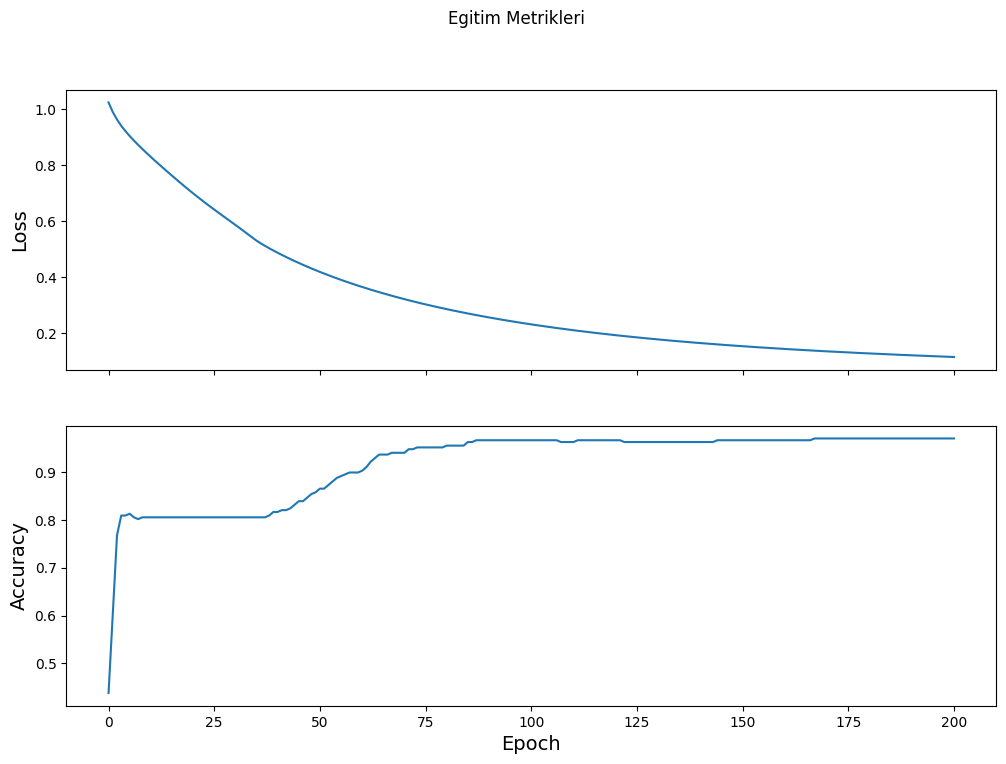

In [21]:
fig, axes = plt.subplots(2, sharex = True, figsize = (12, 8))
fig.suptitle('Egitim Metrikleri')

axes[0].set_ylabel('Loss', fontsize = 14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel('Accuracy', fontsize = 14)
axes[1].set_xlabel('Epoch', fontsize = 14)
axes[1].plot(train_accuracy_results)

plt.show()

# Modelin etkinliğini değerlendirin
Artık model eğitildiğine göre, performansı hakkında bazı istatistiklere ulaşabilirsiniz.

Değerlendirme, modelin tahminleri ne kadar etkili bir şekilde gerçekleştirdiğini belirlemek anlamına gelir. Modelin penguen sınıflandırmasındaki etkinliğini belirlemek için, modele bazı ölçümler aktarın ve modelden bunların hangi penguen türünü temsil ettiğini tahmin etmesini isteyin. Daha sonra modelin tahminlerini gerçek etiketle karşılaştırın.

## Test setini kurun
Modelin değerlendirilmesi, modelin eğitilmesine benzer. En büyük fark, örneklerin eğitim setinden ziyade ayrı bir test setinden gelmesidir. Bir modelin etkinliğini adil bir şekilde değerlendirmek için, modeli değerlendirmek için kullanılan örneklerin, modeli eğitmek için kullanılan örneklerden farklı olması gerekir. Daha oncesinde verileri egitim ve test diye bolmustuk. Boldugumuz test veri setini burada kullanacagiz!

## Modeli test veri kümesinde değerlendirin
Eğitim aşamasının aksine, model yalnızca test verilerinin tek bir dönemini(Epoch) değerlendirir.

In [22]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
  logits = model(x, training = False)
  prediction = tf.math.argmax(logits, axis = 1, output_type = tf.int64)
  test_accuracy(prediction, y)

print('Test set accuracy: {:.3%}'.format(test_accuracy.result()))

Test set accuracy: 97.015%


Test veri kümenizin doğruluk bilgisini almak için model.evaluate(ds_test, return_dict=True) keras fonksiyonunu da kullanabilirsiniz.

In [23]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(7, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [0, 0]])>

# Tahminlerde bulunmak için eğitilmiş modeli kullanın
Bir model eğittiniz ve onun penguen türlerini sınıflandırmada iyi olduğunu, ancak mükemmel olmadığını "kanıtladınız". Şimdi eğitilmiş modeli kullanarak etiketsiz örnekler, yani özellik içeren ancak etiket içermeyen örnekler üzerinde bazı tahminlerde bulunalım.

Gerçek hayatta, etiketlenmemiş örnekler uygulamalar, CSV dosyaları ve veri akışları dahil olmak üzere birçok farklı kaynaktan gelebilir.

In [27]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Adélie (97.6%)
Example 1 prediction: Gentoo (98.5%)
Example 2 prediction: Chinstrap (93.7%)


# Sonuc
Bir çalışmanın daha sonuna geldik. Bu çalışmada, veri seti indirmeyi, modeli adım adım oluşturmayı, sonuçları gözlemlemeyi ve test aşamasını gerçekleştirmeyi ele aldık. TensorFlow’un eğitim bölümlerine ek olarak, kendi bilgilerimi de paylaştım. Bu çalışma ile birlikte Özelleştirme (Customization) bölümünün sonuna geldik. Diğer bölümlerle çalışmalara devam edeceğim.

Umarım bu çalışma sizin için faydalı olmuştur. Eğer bana sormak istediğiniz bir soru olursa, aşağıdaki linklerden benimle iletişime geçebilirsiniz.

İyi çalışmalar dilerim!

[Linkedin](https://www.linkedin.com/in/ihsancenkiz/)<br>
[Github](https://github.com/ihsncnkz)<br>
[Kaggle](https://www.kaggle.com/ihsncnkz)